In [1]:
"""
Part 1: Data preprocessing
"""

'\nPart 1: Data preprocessing\n'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Forex predict using long short term memory')\
        .config('hive.metastore.uris', 'thrift://10.121.31.83:9083')\
        .enableHiveSupport()\
        .getOrCreate()

In [3]:
spark.sql("show databases").show()
spark.sql("use forex")
spark.sql("show tables").show()

+------------------+
|      databaseName|
+------------------+
|           default|
|        first_work|
|             forex|
|information_schema|
|         movie_len|
|               sys|
|              test|
|      titanic_data|
+------------------+

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
|   forex|20120102_eurusd|      false|
|   forex|  201201_eurusd|      false|
|   forex| 2012_m1_eurusd|      false|
|   forex|  201902_eurusd|      false|
|   forex|    2019_eurusd|      false|
|   forex|    2019_minute|      false|
+--------+---------------+-----------+



In [4]:
spark_df = spark.sql("select * from 2012_m1_eurusd")
spark_df.show(5)

+----------+-----+--------+--------+-------+---------+------+
|      date| time|open_bid|high_bid|low_bid|close_bid|volume|
+----------+-----+--------+--------+-------+---------+------+
|2012.01.02|02:00| 1.29324| 1.29381|1.29324|  1.29332|     0|
|2012.01.02|02:01| 1.29326| 1.29345|1.29275|  1.29341|     0|
|2012.01.02|02:02| 1.29342| 1.29344|1.29341|  1.29343|     0|
|2012.01.02|02:03| 1.29342| 1.29342|1.29335|  1.29336|     0|
|2012.01.02|02:04| 1.29324| 1.29347| 1.2932|  1.29346|     0|
+----------+-----+--------+--------+-------+---------+------+
only showing top 5 rows



In [5]:
spark_df.count()

372161

In [6]:
df = spark_df.toPandas()

In [7]:
# get the open price (column _c2)
training_set = df.iloc[:35000,2:3].values

In [8]:
print(training_set.shape)

(35000, 1)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print(type(training_set_scaled))
print(training_set_scaled.shape)
print(training_set_scaled[:10])

<type 'numpy.ndarray'>
(35000, 1)
[[0.50551804]
 [0.50584747]
 [0.50848295]
 [0.50848295]
 [0.50551804]
 [0.51045956]
 [0.51688354]
 [0.52281338]
 [0.5173777 ]
 [0.51902487]]


In [12]:
X_train = []
y_train = []
print(type(X_train))

<type 'list'>


In [13]:
len = training_set_scaled.size

In [14]:
# Creating a data structure with 60 timesteps and 1 output
import numpy as np
for i in range(60, len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape,y_train.shape)

((34940, 60), (34940,))


In [15]:
# Reshaping -> why we need reshape?
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [62]:
"""
Part 2: Building the NN
"""

'\nPart 2: Building the NN\n'

In [16]:
# import keras library: -> need to understand these library usage
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [17]:
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34940/34940 [==============================] - 344s - loss: 0.0046   
Epoch 2/20
34940/34940 [==============================] - 340s - loss: 0.0016   
Epoch 3/20
34940/34940 [==============================] - 341s - loss: 0.0012   
Epoch 4/20
34940/34940 [==============================] - 343s - loss: 9.3739e-04   
Epoch 5/20
34940/34940 [==============================] - 343s - loss: 7.9820e-04   
Epoch 6/20
34940/34940 [==============================] - 341s - loss: 7.2281e-04   
Epoch 7/20
34940/34940 [==============================] - 343s - loss: 7.0020e-04   
Epoch 8/20
34940/34940 [==============================] - 342s - loss: 6.9021e-04   
Epoch 9/20
34940/34940 [==============================] - 343s - loss: 6.7101e-04   
Epoch 10/20
34940/34940 [==============================] - 344s - loss: 6.5997e-04   
Epoch 11/20
34940/34940 [==============================] - 345s - loss: 6.4603e-04   
Epoch 12/20
34940/34940 [==============================] - 344s - loss: 6.2

In [85]:
"""
Part 3: Making the predictions and visualising the results
"""

'\nPart 3: Making the predictions and visualising the results\n'

In [20]:
real_stock_price = df.iloc[35000:37000,2:3].values

In [21]:
inputs = sc.transform(real_stock_price)

In [22]:
training_set_scaled

array([[0.50551804],
       [0.50584747],
       [0.50848295],
       ...,
       [0.80678636],
       [0.80975128],
       [0.8118926 ]])

In [23]:
test_len = inputs.size

In [24]:
test_len

2000

In [25]:
X_test = []

In [26]:
for i in range(60, test_len):
    X_test.append(inputs[i-60:i, 0])

In [27]:
X_test = np.array(X_test)

In [28]:
X_test.shape

(1940, 60)

In [29]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [30]:
predicted_stock_price = regressor.predict(X_test)

In [31]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [32]:
predicted_stock_price.size

1940

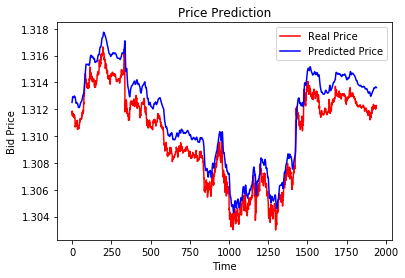

In [33]:
# Visualising the results
plt.plot(real_stock_price[60:], color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.legend()
plt.show()